<a href="https://colab.research.google.com/github/shahbaz1982/SEIR/blob/main/SEIR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 0, Total Loss: 0.044570017606019974
Iteration 500, Total Loss: 2.6249256279697875e-06
Iteration 1000, Total Loss: 3.887402613145241e-07
Iteration 1500, Total Loss: 8.4501415642535e-08
Iteration 2000, Total Loss: 1.7047909750544932e-07
Iteration 2500, Total Loss: 2.992415204516874e-08
Iteration 3000, Total Loss: 2.599993287333291e-08
Iteration 3500, Total Loss: 2.9332158035799694e-08
Iteration 4000, Total Loss: 4.1452309233136475e-05
Iteration 4500, Total Loss: 1.0755526318462216e-06


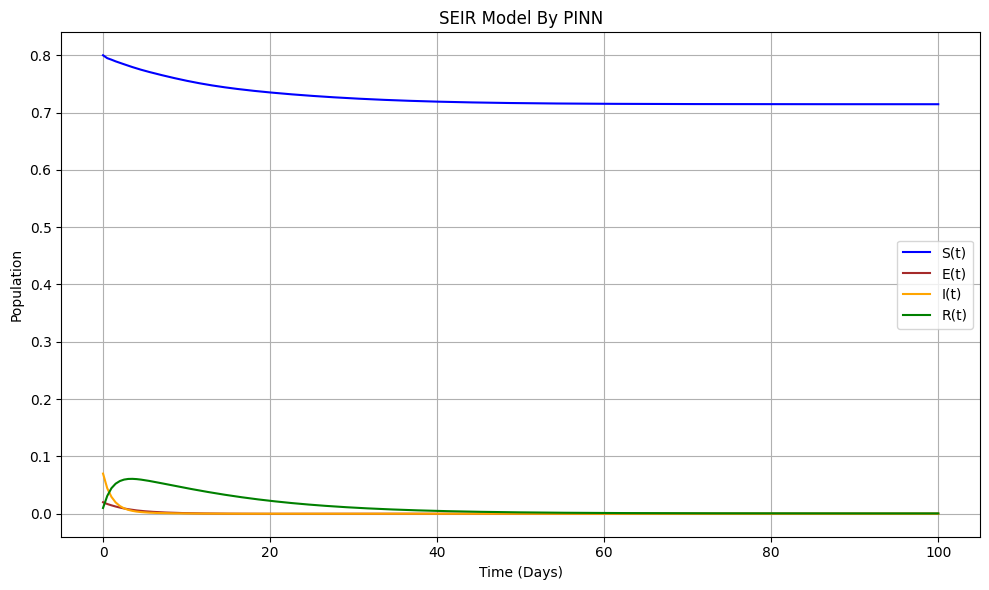

tensor([[ 8.0000e-01,  2.0001e-02,  6.9982e-02,  9.9981e-03],
        [ 7.9493e-01,  1.6949e-02,  4.4404e-02,  3.0992e-02],
        [ 7.9231e-01,  1.4640e-02,  2.9388e-02,  4.4481e-02],
        [ 7.8937e-01,  1.2553e-02,  1.9723e-02,  5.2393e-02],
        [ 7.8677e-01,  1.0734e-02,  1.3439e-02,  5.6967e-02],
        [ 7.8431e-01,  9.1668e-03,  9.3741e-03,  5.9518e-02],
        [ 7.8182e-01,  7.8229e-03,  6.7074e-03,  6.0651e-02],
        [ 7.7937e-01,  6.6847e-03,  4.9224e-03,  6.0818e-02],
        [ 7.7705e-01,  5.7299e-03,  3.7041e-03,  6.0367e-02],
        [ 7.7487e-01,  4.9300e-03,  2.8561e-03,  5.9531e-02],
        [ 7.7282e-01,  4.2562e-03,  2.2534e-03,  5.8451e-02],
        [ 7.7085e-01,  3.6837e-03,  1.8150e-03,  5.7218e-02],
        [ 7.6896e-01,  3.1928e-03,  1.4881e-03,  5.5887e-02],
        [ 7.6712e-01,  2.7684e-03,  1.2381e-03,  5.4498e-02],
        [ 7.6531e-01,  2.3993e-03,  1.0419e-03,  5.3074e-02],
        [ 7.6355e-01,  2.0766e-03,  8.8435e-04,  5.1634e-02],
        

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random

# Define the fully connected neural network (FCN)
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        self.fch = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
            ) for _ in range(N_LAYERS - 1)
        ])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, t):
        t = self.fcs(t)
        t = self.fch(t)
        t = self.fce(t)
        return t

torch.manual_seed(123)

# Instantiate the PINN model
pinn = FCN(1, 4, 64, 4)

# Define t_boundary for initial conditions
t_boundary = torch.tensor([[0.0]], requires_grad=True)

# Define interior points for the physics-informed loss
t_physics = torch.linspace(0, 100, 200).view(-1, 1).requires_grad_(True)

# Test points for evaluating the solution
t_test = torch.linspace(0, 100, 200).view(-1, 1)

# Training loop
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-2)
lambda1, lambda2 = 0.01, 1.0

# For plotting S_physics, E_physics, I_physics, and R_physics
S_physics_plots = []
E_physics_plots = []
I_physics_plots = []
R_physics_plots = []
# Initial conditions
S0 = 0.8
E0 =  0.02
I0 = 0.07
R0 = 0.01
# Parameters
A = 0.05
beta = 0.01
sigma = 0.25
mu = 0.07
alpha = 0.07
gamma = 0.8

for i in range(5000):
    optimiser.zero_grad()

    # Enforce initial conditions:
    u_t_boundary = pinn(t_boundary)
    S_boundary = u_t_boundary[:, 0:1]  # First output is S(t)
    E_boundary = u_t_boundary[:, 1:2]  # Second output is E(t)
    I_boundary = u_t_boundary[:, 2:3]  # Third output is I(t)
    R_boundary = u_t_boundary[:, 3:4]  # Fourth output is R(t)
    loss_ic = torch.mean((S_boundary - S0)**2 + (E_boundary - E0)**2 +  (I_boundary - I0)**2 + (R_boundary - R0)**2)

    # Physics-informed loss for the interior points
    u_t_physics = pinn(t_physics)
    S_physics = u_t_physics[:, 0:1]  # First output is S(t)
    E_physics = u_t_physics[:, 1:2]  # Second output is E(t)
    I_physics = u_t_physics[:, 2:3]  # Third output is I(t)
    R_physics = u_t_physics[:, 3:4]  # Fourth output is R(t)

    # Compute dS/dt, dI/dt, dR/dt using autograd
    dS_dt = torch.autograd.grad(
        outputs=S_physics,
        inputs=t_physics,
        grad_outputs=torch.ones_like(S_physics),
        create_graph=True
    )[0]

    dE_dt = torch.autograd.grad(
        outputs=E_physics,
        inputs=t_physics,
        grad_outputs=torch.ones_like(E_physics),
        create_graph=True
    )[0]

    dI_dt = torch.autograd.grad(
        outputs=I_physics,
        inputs=t_physics,
        grad_outputs=torch.ones_like(I_physics),
        create_graph=True
    )[0]

    dR_dt = torch.autograd.grad(
        outputs=R_physics,
        inputs=t_physics,
        grad_outputs=torch.ones_like(R_physics),
        create_graph=True
    )[0]

    # Physics-informed losses using the ODEs
    loss_ode_S = torch.mean((dS_dt - A +  mu * S_physics + beta * S_physics * I_physics )**2)
    loss_ode_E = torch.mean((dE_dt - beta * S_physics * I_physics + ( sigma + mu) * E_physics)**2)
    loss_ode_I = torch.mean((dI_dt - sigma * E_physics + (alpha + mu + gamma) * I_physics)**2)
    loss_ode_R = torch.mean((dR_dt - gamma * I_physics + mu * R_physics)**2)

    # Total physics-informed loss
    loss_ode = loss_ode_S + loss_ode_I + loss_ode_R + loss_ode_E

    # Total loss
    loss = lambda1 * loss_ic + lambda2 * loss_ode
    loss.backward()
    optimiser.step()

    # Print the loss every 500 epochs
    if i % 500 == 0:
        print(f"Iteration {i}, Total Loss: {loss.item()}")

    # Save S_physics, E_physics, I_physics, and R_physics for plotting every 500 epochs
    if i % 500 == 0:
        S_physics_plots.append(S_physics.detach().numpy())
        E_physics_plots.append(E_physics.detach().numpy())
        I_physics_plots.append(I_physics.detach().numpy())
        R_physics_plots.append(R_physics.detach().numpy())

# Plot all the data in one figure
plt.figure(figsize=(10, 6))  # Create figure with specified size

# Plot S(t) (Susceptible)
plt.plot(t_physics.detach().numpy(), S_physics.detach().numpy(), label="S(t)", color='blue')

# Plot E(t) (Exposed)
plt.plot(t_physics.detach().numpy(), E_physics.detach().numpy(), label="E(t)", color='brown')

# Plot I(t) (Infected)
plt.plot(t_physics.detach().numpy(), I_physics.detach().numpy(), label="I(t)", color='orange')

# Plot R(t) (Recovered)
plt.plot(t_physics.detach().numpy(), R_physics.detach().numpy(), label="R(t)", color='green')

# Add labels and title
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.title("SEIR Model By PINN")

# Add a grid and legend
plt.grid(True)
plt.legend()

# Show the combined plot
plt.tight_layout()
plt.show()
print(u_t_physics)